###SGC model using torch geometric with Cora

In [16]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install numpy==1.23.5


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 40.4 MB/s eta 0:00:00
^C
^C


In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SGConv
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn.functional as F


In [2]:
# **************** IMPORT DATA ********************
dataset = Planetoid(root='/tmp/Cora', name='Cora')  # Colab compatible path
data = dataset[0]
print('Cora dataset:', data)


Cora dataset: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move all data to the selected device
data = data.to(device)


Using device: cuda


In [4]:
# **************** CONSTRUCT THE MODEL ********************
class SGCNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(
            in_channels=dataset.num_features,
            out_channels=dataset.num_classes,
            K=2,  # Increased from 1 for better performance
            cached=True
        )

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)

SGC_model = SGCNet().to(device)


In [5]:
# **************** GET EMBEDDING ********************
print("\nShape verification:")
print("Original data shape:", data.x.shape)
with torch.no_grad():
    embeddings = SGC_model.conv1(data.x, data.edge_index)
    print("Embedding shape:", embeddings.shape)



Shape verification:
Original data shape: torch.Size([2708, 1433])
Embedding shape: torch.Size([2708, 7])


In [6]:
# **************** TRAINING SETUP ********************
optimizer = torch.optim.Adam(SGC_model.parameters(), lr=0.2, weight_decay=5e-4)

# Print model parameters
print("\nModel parameters:")
for name, param in SGC_model.named_parameters():
    print(f"{name}: shape {param.shape}")



Model parameters:
conv1.lin.weight: shape torch.Size([7, 1433])
conv1.lin.bias: shape torch.Size([7])


In [7]:
# **************** TRAIN FUNCTION ********************
def train():
    SGC_model.train()
    optimizer.zero_grad()
    out = SGC_model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


In [8]:
# **************** TEST FUNCTION ********************
@torch.no_grad()
def test():
    SGC_model.eval()
    logits = SGC_model(data.x, data.edge_index)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


In [9]:
# **************** TRAINING LOOP ********************
print("\nStarting training...")
best_val_acc = test_acc = 0
for epoch in range(1, 101):
    train_loss = train()
    train_acc, val_acc, current_test_acc = test()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = current_test_acc

    if epoch % 10 == 0:
        log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
        print(log.format(epoch, train_loss, train_acc, val_acc, test_acc))



Starting training...
Epoch: 010, Loss: 0.0111, Train: 1.0000, Val: 0.7500, Test: 0.7860
Epoch: 020, Loss: 0.0604, Train: 1.0000, Val: 0.7660, Test: 0.7860
Epoch: 030, Loss: 0.0571, Train: 1.0000, Val: 0.7640, Test: 0.7860
Epoch: 040, Loss: 0.0557, Train: 1.0000, Val: 0.7780, Test: 0.7860
Epoch: 050, Loss: 0.0549, Train: 1.0000, Val: 0.7800, Test: 0.7860
Epoch: 060, Loss: 0.0544, Train: 1.0000, Val: 0.7800, Test: 0.8090
Epoch: 070, Loss: 0.0544, Train: 1.0000, Val: 0.7820, Test: 0.8090
Epoch: 080, Loss: 0.0539, Train: 1.0000, Val: 0.7780, Test: 0.8090
Epoch: 090, Loss: 0.0539, Train: 1.0000, Val: 0.7800, Test: 0.8090
Epoch: 100, Loss: 0.0538, Train: 1.0000, Val: 0.7800, Test: 0.8090



Visualizing embeddings...


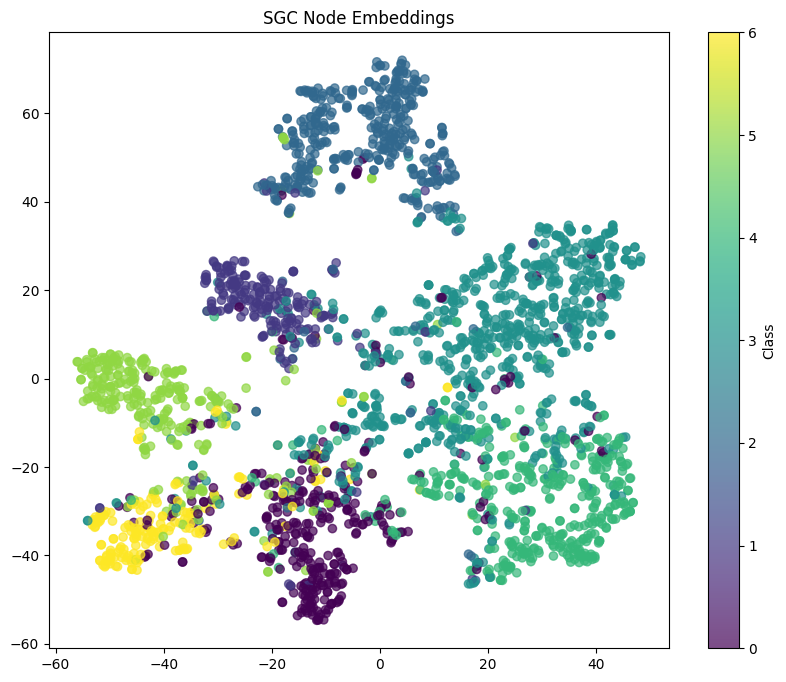

In [10]:
# **************** VISUALIZATION ********************
@torch.no_grad()
def visualize_embeddings():
    SGC_model.eval()
    embeddings = SGC_model.conv1(data.x, data.edge_index).cpu().numpy()
    labels = data.y.cpu().numpy()

    # Dimensionality reduction
    try:
        from sklearn.manifold import TSNE
        emb_2d = TSNE(n_components=2).fit_transform(embeddings)
    except:
        from sklearn.decomposition import PCA
        emb_2d = PCA(n_components=2).fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Class')
    plt.title("SGC Node Embeddings")
    plt.show()

print("\nVisualizing embeddings...")
visualize_embeddings()